- Abstract

> Stock price movement prediction is commonly accepted as a very challenging task due to the volatile nature of financial markets.

> Previous works typically predict the stock price mainly based on its own information, neglecting the cross effect among involved stocks.

> However, it is well known that an individual stock price is correlated with prices of other stocks in complex ways.

> To take the cross effect into consideration, we propose a deep learning framework, called Multi-GCGRU, which comprises GCN and GRU(Gated Recurrent Unit) to predict stock movement.

> We first encode multiple relationships among stocks into graphs based on financial domain knowledge and utilize GCN to extract the cross effect based on these pre-defined graphs.

> To further get rid of prior knowledge, we explore an adaptive relationship learned by data automatically.

> The cross-correlation features produced by GCN are concatenated with historical records and then fed into GRU to model the temporal dependency of stock prices.

- Labelling Issue

> stock price prediction can be divided into stock price return prediction and stock movement prediction where the former predicts the exact price of stock while the latter predicts the up or down of stock price.

> Due to the complexity and stochasticity of stock market, it is rather difficult to predict price return but stock movement prediction is more achievable.

> Loss function : cross entropy function

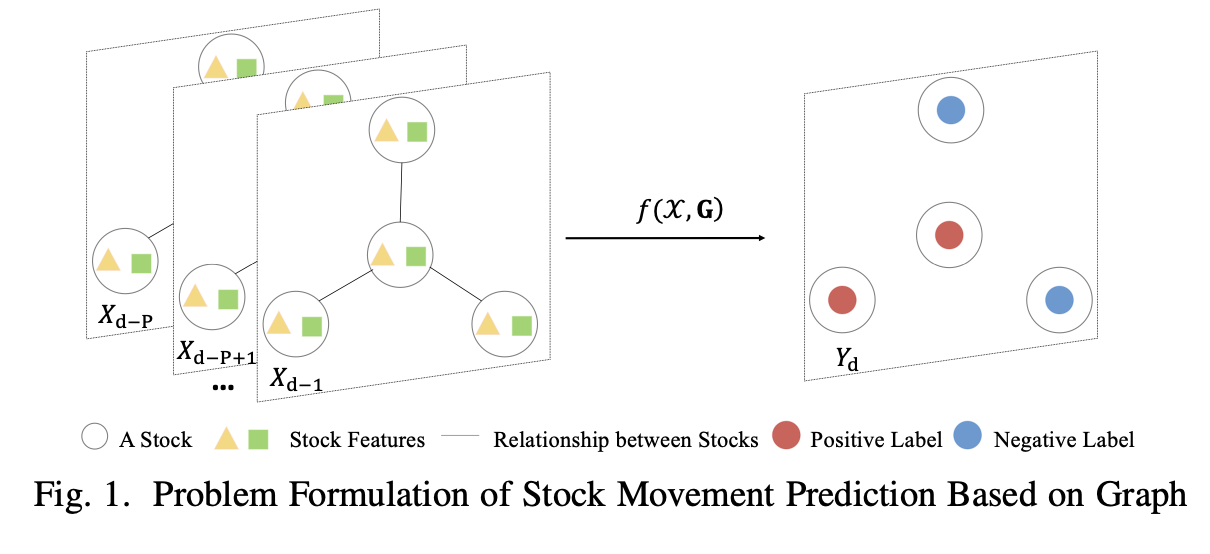

Multi-GCGRU architecture in our paper aims to predict the stock price movement by considering both historical records of individual stock and cross effect from other related stocks.

- First Stage

extract relationships which can explaiin the cross effect among stocks by encoding them into graphs.
(e.g. Shareholding graph. Industry Graph. Topicality Graph)

- Second Stage

Learn more complicated and dynamic cross-correlation behind stock collection by GCN.

- Third Stage

Utilize GRU to learn the temporal dependency by historical records along with higher features containing cross effect produced by Multi-GCN. Finally, a fully connected layer with sigmoid activation function is added to get the probability prediction.


---



A. Graph Construction
- The cross-autocorrelation of stock returns over time has long been recognized in stock markets

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
path = "/content/CSI500 concepts.xlsx"
T = pd.read_excel(path, index_col=0).values
path = "/content/CSI500 industry.xlsx"
I = pd.read_excel(path, index_col=0).values
path = "/content/CSI500 shareholders.xlsx"
S = pd.read_excel(path, index_col=0).values
print(T.shape, I.shape, S.shape) #(N,N)
Fixed_Matrices = [S,I,T]

M=5
P=240
N=10
F=2
'''
samples: the input data
labels: the labels of input data
M: the number of samples
P: the historical length
N: the number of related stocks
F: the number of stock features
'''


(2858, 3) (489, 5) (4930, 5)


'\nsamples: the input data\nlabels: the labels of input data\nM: the number of samples\nP: the historical length\nN: the number of related stocks\nF: the number of stock features\n'

In [14]:
Fixed_Matrices[0]

array([[20190330, 20181231, '中国农业银行股份有限公司-华夏中证央企结构调整交易型开放式指数证券投资基金',
        2872000, 0.14],
       [20190330, 20181231, '东风汽车有限公司', 1202000000, 60.1],
       [20190330, 20181231, '中央汇金资产管理有限责任公司', 54766900, 2.74],
       ...,
       [20190426, 20181231, '绍兴上虞硅谷科信投资合伙企业(有限合伙)', 93169959, 4.73],
       [20190426, 20181231, '杭州艾泽拉思投资管理合伙企业(有限合伙)', 94979085, 4.82],
       [20190426, 20181231, '绍兴上虞朱雀股权投资合伙企业(有限合伙)', 194939647, 9.89]],
      dtype=object)

In [5]:

samples = np.random.normal(size=(M,P,N,F))
labels = np.random.normal(size=(M,N))

In [6]:
'''
train set = 70%
test set = 20%
val set = 10%
'''

TEST_SIZE=0.3
RANDOM_STATE=5
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(samples, labels,test_size=TEST_SIZE, random_state=RANDOM_STATE)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.33, random_state=RANDOM_STATE)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(3, 240, 10, 2) (3, 10)
(1, 240, 10, 2) (1, 10)
(1, 240, 10, 2) (1, 10)


In [7]:
# Numpy to tensor

X_train = tf.constant(X_train, dtype=tf.float32)
y_train = tf.constant(y_train, dtype=tf.float32)
X_test = tf.constant(X_test, dtype=tf.float32)
y_test = tf.constant(y_test, dtype=tf.float32)
X_val = tf.constant(X_val, dtype=tf.float32)
y_val = tf.constant(y_val, dtype=tf.float32)

In [15]:
### Model

class GCGRU(tf.keras.Model):
  def __init__(self, N, F, Units_GCN, Units_GRU, Units_FC,
               Fixed_Matrices, Matrix_Weights, Is_Dyn,
               kernel_initializer ='glorot_uniform',
               bias_initializer='zeros'):
    super(GCGRU, self).__init__()

    # Number of Nodes
    self.N=N
    # the number of input features
    self.F=F
    # pre-defined matrices: shape=[(N,N),(N,N),(N,N)]
    self.mat = Fixed_Matrices
    # Dynamic Matrix:shape=(N,N)
    self.dyn = self.add_weight(name='w_Dynamic', shape=(self.N, self.N),
                               initializer=tf.keras.initializers.get(kernel_initializer),
                               trainable=True)
    if Is_Dyn:
      self.mats = self.dyn
    else:
      self.mats = self.add_weight(name='w_Matrices', shape=(self.N, self.N),
                                  initializer=tf.keras.initializers.get(kernel_initializer),
                                  trainable=True)
      for i in range(len(Matrix_Weights)):
        coe = tf.Variable(1.0, trainable=True)
        self.mats = self.mats + Matrix_Weights[i]*self.mat[i]*coe
        print(i)

    # GCN_Weights
    self.units_gcn = Units_GCN
    self.w_gcn = []
    self.b_gcn = []
    pre = self.F
    for i in range(len(self.units_gcn)):
      aft = self.units_gcn[i]
      w = self.add_weight(name='w_GCN', shape=(pre, aft),
                          initializer = tf.keras.initializers.get(kernel_initializer),
                          trainable=True)
      self.w_gcn.append(w)
      b = self.add_weight('b_GCN',shape=(aft,),
                          initializer=tf.keras.initializers.get(bias_initializer),
                          trainable=True)
      self.b_gcn.append(b)
      pre=aft

    # GRU_Weights
    self.units_gru = Units_GRU
    self.w_gru=[]
    self.b_gru=[]

    # the number of output features of Multi-GCN
    C = self.units_gcn[-1]
    F = self.F
    for i in range(len(self.units_gru)-1):
      H=self.units_gru[i]
      pre = F+C+H
      aft = H
      for j in range(3):
        w = self.add_weight(name='w_GRU', shape=(pre,aft),
                            initializer=tf.keras.initializers.get(kernel_initializer),
                            trainable=True)
        self.w_gru.append(w)
        b = self.add_weight(name='b_GRU', shape=(aft,),
                            initializer=tf.keras.initializers.get(bias_initializer),
                            trainable=True)
        self.b_gru.append(b)
      F=aft

    # the last layer weights
    H = self.units_gru[-2]
    G = self.units_gru[-1]
    w = self.add_weight(name='w_GRU', shape=(H,G),
                        initializer=tf.keras.initializers.get(kernel_initializer),
                        trainable=True)
    self.w_gru.append(w)
    b = self.add_weight(name='b_GRU', shape=(G,),
                        initializer=tf.keras.initializers.get(bias_initializers),
                        trainable=True)
    self.b_gru.append(b)

    # FC_weights
    self.units_fc = Units_FC
    self.w_fc = []
    self.b_fc = []
    pre = G

    for i in range(len(self.units_fc)):
      aft = self.units_fc[i]
      w = self.add_weight(name='w_FC', shape=(pre,aft),
                          initializer=tf.keras.initializers.get(kernel_initializer),
                          trainable=True)
      self.w_fc.append(w)
      b = self.add_weight(name='b_FC', shape=(aft,),
                          initializer=tf.keras.initializers.get(bias_initializer),
                          trainable=True)
      self.b_fc.append(b)
      pre = aft

  def Multi_GCN(self, inputs):
    P = inputs.shape[1]
    x_gcn=[]
    for t in range(P):
      xt_gcn = inputs[:,t,:,:]

      for i in range(len(self.units_gcn)):
        xt_gcn = self.mats @ xt_gcn @ self.w_gcn[i] + self.b_gcn[i]
        xt_gcn = tf.nn.tanh(xt_gcn)
      x_gcn.append(xt_gcn)
    # (None,P,N,C)
    x_gcn = tf.stack(x_gcn, axis=1)
    return x_gcn
  def GRU(self, x, x_gcn):
    h_gru=[]

    # (None, P, N ,F)=>(None, N, F)*(F,H)=> (None, N, H)
    for i in range(len(self,units_gru)-1):
      H = self.units_gru[i]
      h = tf.zeros_like(x[:,0,:,:], dtype=tf.float32) @ tf.zeros([F,H])
      h_gru.append(h)

    # all gru layers at each time step
    for t in range(P):
      xt_gcn = x_gcn[:,t,:,:]
      xt = x[:,t,:,:]

      for i in range(len(h_gru)):
        ht_1 = h_gru[i]
        x_tgh = tf.concat([xt,xt_gcn,ht_1], axis=2)

        ut = tf.nn.sigmoid(x_tgh @ self.w_gru[3*i+0] + self.b_gru[3*i+0])
        rt = tf.nn.sigmoid(x_tgh @ self.w_gru[3*i+1] + self.b_gru[3*i+1])

        x_tghr = tf.concat([xt, xt_gcn, tf.multiply(rt, ht_1)], axis=2)

        ct = tf.nn.tanh(x_tghr @ self.w_gru[3*i+2] + self.b_gru[3*i+2])
        ht = tf.multiply(ut, ht_1)+tf.multiply((1-ut),ct)
        xt=ht
        h_gru[i]=ht
    x_gru = tf.nn.sigmoid(ht @ self.w_gru[-1] + self.b_gru[-1])
    return x_gru

  def FC(self, x_gru):
    x=x_gru

    for i in range(len(self.w_fc)):
      x = x @ self.w_fc[i] + self.b_fc[i]
      x = tf.nn.sigmoid(x)
    x_fc = tf.squeeze(x, aixs=-1)
    return x_fc

  def build(self, input_shape):
    super().build(input_shape)

  def call(self, inputs):
    x_gcn = self.Multi_GCN(inputs)
    x_gru = self.GRU(inputs, x_gcn)
    x_fc = self.FC(x_gru)
    return x_fc


In [16]:
Units_GCN = [16,32]
Units_GRU = [16,32]
Units_FC = [1]
Matrix_Weights = [1,1,1]
Is_Dyn = False

model = GCGRU(N,F,Units_GCN, Units_GRU,Units_FC,Fixed_Matrices, Matrix_Weights, Is_Dyn)
model.build(input_shape=(None, P,N,F))
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.BinaryAccuracy()])
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = './h5/500-GCGRU',
    monitor = 'val_binary_accuracy',
    save_weights_only = True,
    save_best_only = True
)

Epochs = 1000
Batch_size=32
History = model.fit(X_train, y_train, batch_size=Batch_size, epochs=Epochs,
                    callbacks=[model_checkpoint], validation_data=(X_val, y_val))

# Overfitting Observation
loss = History.history['loss']
val_loss = History.history['val_loss']
E = [i for i in range(Epochs)]
plt.plot(E, loss, 'b-', label='loss')
plt.plot(E, val_loss, 'r--', label='val_loss')
plt.legend()
plt.title('Loss VS Val_loss')

# Prediction
model.load_weights('./h5/500-GCN')
result = model.evaluate(X_test, y_test)
print(result)

ValueError: ignored